In [1]:
from astropy.io import fits
from pathlib import Path
import os, sys
from numba import njit 
SRC_DIR = str(Path('.').resolve().parents[1])
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

import utils

import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

### $\xi^{(i,j)}_\theta$ definition

In [19]:
@njit
def _H_LCDM(z, H0, Omega_m_0):
    return H0 * np.sqrt(Omega_m_0 * (1.0 + z)**3 + (1.0 - Omega_m_0))

@njit
def _E_LCDM(z, Omega_m_0):
    return np.sqrt(Omega_m_0 * (1.0 + z)**3 + (1.0 - Omega_m_0))

@njit
def integral_trapezoid_inv_H_LCDM(a, b, N, c, H0, Omega_m):
    step = (b - a) / N
    result = 0.5 * (1.0 / _E_LCDM(a, Omega_m) + 1.0 / _E_LCDM(b, Omega_m))
    for i_step in range(1, N):
        result += 1.0 / _E_LCDM(a + i_step * step, Omega_m)
    return (c / H0) * step * result

@njit
def get_chi(z, H0, Omega_m, c):
    return integral_trapezoid_inv_H_LCDM(a=0, b=z, N=1000000, c=c, H0=H0, Omega_m=Omega_m)
    
@njit
def get_z(chi_val, chi_vals, z_vals):
    if chi_val <= chi_vals[0]:
        return z_vals[0]
    if chi_val >= chi_vals[-1]:
        return z_vals[-1]
    i = np.searchsorted(chi_vals, chi_val) - 1
    t = (chi_val - chi_vals[i]) / (chi_vals[i+1] - chi_vals[i])
    return z_vals[i] * (1.0 - t) + z_vals[i+1] * t

@njit
def get_n(i_bin, z, z_n_bins_list, n_bins_list):
    Nz = z_n_bins_list.size
    if z <= z_n_bins_list[0]:
        return n_bins_list[0, i_bin]
    if z >= z_n_bins_list[-1]:
        return n_bins_list[-1, i_bin]
    idx = np.searchsorted(z_n_bins_list, z) - 1
    t = (z - z_n_bins_list[idx]) / (z_n_bins_list[idx+1] - z_n_bins_list[idx])
    return n_bins_list[idx, i_bin] * (1.0 - t) + n_bins_list[idx+1, i_bin] * t

@njit
def integrand_q(chi_val_integrand, chi_val_W, chi_vals, z_vals, z_n_bins_list, n_bins_list, i, H0, Omega_m, c):
    z_chi_integrand = get_z(chi_val_integrand, chi_vals, z_vals)
    dz_dchi_integrand = _H_LCDM(z_chi_integrand, H0, Omega_m) / c
    n_i_z = get_n(i_bin=i, z=z_chi_integrand, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list)
    return n_i_z * dz_dchi_integrand * (chi_val_integrand - chi_val_W) / chi_val_integrand

@njit
def integral_trapezoid_q(a, b, N, chi_val_W, chi_vals, z_vals, z_n_bins_list, n_bins_list, i, H0, Omega_m, c):
    step = (b - a) / N
    result = 0.5 * (integrand_q(a, chi_val_W, chi_vals, z_vals, z_n_bins_list, n_bins_list, i, H0, Omega_m, c) + integrand_q(b, chi_val_W, chi_vals, z_vals, z_n_bins_list, n_bins_list, i, H0, Omega_m, c))
    for i_step in range(1, N):
        result += integrand_q(a + i_step * step, chi_val_W, chi_vals, z_vals, z_n_bins_list, n_bins_list, i, H0, Omega_m, c)
    return step * result

@njit
def q(i, chi_val, z_chi_val, chi_vals, z_vals, z_n_bins_list, n_bins_list, chi_H, H0, Omega_m, c):
    integral = integral_trapezoid_q(a=chi_val, b=chi_H, N=100, chi_val_W=chi_val, chi_vals=chi_vals, z_vals=z_vals, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list, i=i, H0=H0, Omega_m=Omega_m, c=c)
    return integral

@njit
def integrand_ClEE(chi_val, i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list):
    z_chi_val = get_z(chi_val=chi_val, chi_vals=chi_vals, z_vals=z_vals)
    P_cal = utils.cosmo.P(k=(l+0.5)/chi_val, z=z_chi_val, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact)
    return (1 + z_chi_val)**2 * q(i=i, chi_val=chi_val, z_chi_val=z_chi_val, chi_vals=chi_vals, z_vals=z_vals, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list, chi_H=chi_H, H0=H0, Omega_m=Omega_m, c=c) * q(i=j, chi_val=chi_val, z_chi_val=z_chi_val, chi_vals=chi_vals, z_vals=z_vals, z_n_bins_list=z_n_bins_list, n_bins_list=n_bins_list, chi_H=chi_H, H0=H0, Omega_m=Omega_m, c=c) * P_cal

@njit
def integral_trapezoid_ClEE(a, b, N, i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list):
    step = (b - a) / N
    result = 0.5 * (integrand_ClEE(a, i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list) + integrand_ClEE(b, i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list))
    for i_step in range(1, N):
        result += integrand_ClEE(a + i_step * step, i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list)
    return step * result

@njit
def ClEE(i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list):
    return ((3 * Omega_m * H0**2) / (2 * c**2)) ** 2 * integral_trapezoid_ClEE(a=1e-6, b=chi_H, N=1000, i=i, j=j, l=l, H0=H0, Omega_m=Omega_m, Omega_b=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s, fact=fact, chi_H=chi_H, chi_vals=chi_vals, z_vals=z_vals, n_bins_list=n_bins_list, z_n_bins_list=z_n_bins_list)

@njit
def ClBB(i, j, l):
    return 0.0

# @njit
def xip_integrand(l, theta, i, j, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list):
    return l * (ClEE(i, j, l, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list) + ClBB(0, 0, 0)) * j0(l * theta)

# @njit
def integral_trapezoid_xip(a, b, N, theta, i, j, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list):
    step = (b - a) / N
    result = 0.5 * (xip_integrand(a, theta, i, j, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list) + xip_integrand(b, theta, i, j, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list))
    for i_step in range(1, N):
        result += xip_integrand(a + i_step * step, theta, i, j, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list)
        print(f"{i_step}/{N}: {step * result / (2 * np.pi)} ")
    return step * result / (2 * np.pi)

# @njit
def xip_flat_sky(i_theta, theta, i, j, dl22_vals, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list, nb_l):
    return integral_trapezoid_xip(0, 15000, 1000, theta, i, j, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals, n_bins_list, z_n_bins_list)

def chi2_desy3(des_fulldata, nb_l, dl22_vals, H0, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_star, A_s, fact, chi_H, chi_vals, z_vals):
    xip_fulldata, xim_fulldata = des_fulldata[0], des_fulldata[1]
    N_xip = len(xip_fulldata[0])
    N_xim = len(xim_fulldata[0])
    N = N_xip + N_xim

    delta_xi = np.empty(N)
    for i in range(1): ## N
        if i < N_xip:
            val = xip_flat_sky(i_theta=i,
                                                    theta=xip_fulldata[1][i],
                                                    i=xip_fulldata[2][i],
                                                    j=xip_fulldata[3][i],
                                                    dl22_vals=dl22_vals,
                                                    H0=H0,
                                                    Omega_m=Omega_m,
                                                    Omega_b=Omega_b,
                                                    Omega_gamma=Omega_gamma,
                                                    h=h,
                                                    c=c,
                                                    n_s=n_s,
                                                    k_star=k_star,
                                                    A_s=A_s,
                                                    fact=fact,
                                                    chi_H=chi_H,
                                                    chi_vals=chi_vals,
                                                    z_vals=z_vals,
                                                    n_bins_list=des_fulldata[2],
                                                    z_n_bins_list=des_fulldata[3],
                                                    nb_l=nb_l)
            delta_xi[i] = xip_fulldata[0][i] - val
        elif N_xip <= i < N_xim:
            pass

    print(f'diff={delta_xi[0]}, calculé={val}, théorique={xip_fulldata[0][i]}')
    return delta_xi @ des_fulldata[4] @ delta_xi

In [ ]:
import numpy as np
# from sympy.physics.wigner import wigner_d
# from sympy import N
from scipy.special import j0, jv
from numpy.fft import fft, ifft, fftfreq

file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    # hdul.info()
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

z_vals_des = nz_data_des['Z_MID']
covmat_desy3 = covmat[:400, :400]
covmat_kids = covmat[400:, 400:]

z_vals_kids = nz_source_kids['Z_MID']
n_bin1 = nz_data_des['BIN1']

xi_minus_data = xim_data['VALUE']
xi_minus_ang = xim_data['ANG']
xi_plus_data = xip_data['VALUE']
xi_plus_ang = xip_data['ANG']

nb_l = 50

H0 = 73.4
h = 0.674
c = 299792.458
Omega_m = 0.315
sigma8 = 0.811
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
n_s = 0.965
k_star = 0.05
R_8 = 8

def As(sigma8):
    return 2.1e-9 * (sigma8 / 0.811)**2
    
A_s = As(sigma8)

z_max_horizon = 1e6
chi_H = get_chi(z_max_horizon, H0, Omega_m, c)
print(f"chi_H={chi_H}")

N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

z_vals = np.logspace(-10, np.log10(10), 1000)
chi_vals = get_chi(z=z_vals, H0=H0, Omega_m=Omega_m, c=c)

des_xip_fulldata = [xip_data['VALUE'], # xip
                    xip_data['ANG'] * np.pi /(60 * 180), # theta
                    xip_data['BIN1'], # i
                    xip_data['BIN2'], # j
                    ]

des_xim_fulldata = [xim_data['VALUE'], # xim
                    xim_data['ANG'] * np.pi /(60 * 180), # theta
                    xim_data['BIN1'], # i
                    xim_data['BIN2'], # j
                    ]

n1 = nz_data_des['BIN1'].astype(np.float64)
n2 = nz_data_des['BIN2'].astype(np.float64)
n3 = nz_data_des['BIN3'].astype(np.float64)
n4 = nz_data_des['BIN4'].astype(np.float64)
z_s = nz_data_des['Z_MID'].astype(np.float64)

n1 /= np.sum(n1)
n2 /= np.sum(n2)
n3 /= np.sum(n3)
n4 /= np.sum(n4)

des_fulldata = [des_xip_fulldata,
                des_xim_fulldata,
                np.column_stack((n1,                     # n_i(z) for i = 1
                                n2,                      # ...
                                n3,                      # ...
                                n4)).astype(np.float64), # n_i(z) for i = 4
                z_s,                                     # z in n_i(z)
                covmat_desy3,
                ]

def d22l_rec_P(theta, lmax, eps=1e-12):
    theta = np.asarray(theta)
    x = np.cos(theta)
    ntheta = x.size

    d22 = np.zeros((ntheta, lmax+1), dtype=float)

    Pm2 = np.zeros((lmax+1, ntheta), dtype=float)
    Pm2[2, :] = 3 * (1 - x**2)

    if lmax >= 3:
        Pm2[3, :] = 15 * x * (1 - x**2)

    m = 2
    for l in range(4, lmax+1):
        Pm2[l, :] = ((2*l - 1) * x * Pm2[l-1, :] - (l + m - 1) * Pm2[l-2, :]) / (l - m)

    for l in range(2, lmax+1):
        norm = np.sqrt(1 / ((l+2) * (l+1) * l * (l-1)))
        d22[:, l] = norm * Pm2[l, :]

dl22_vals = d22l_rec_P(des_xip_fulldata[1], nb_l)

res = chi2_desy3(des_fulldata=des_fulldata,
        nb_l=nb_l,
        dl22_vals=dl22_vals,
        H0=H0,
        Omega_m=Omega_m,
        Omega_b=Omega_b,
        Omega_gamma=Omega_gamma,
        h=h,
        c=c,
        n_s=n_s,
        k_star=k_star,
        A_s=A_s,
        fact=fact,
        chi_H=chi_H,
        chi_vals=chi_vals,
        z_vals=z_vals)

chi_H=20891.633613006376
1/1000: 1.984982748948538e-08 
2/1000: 5.347137860872092e-08 
3/1000: 9.221448855692341e-08 
4/1000: 1.30794950408043e-07 
5/1000: 1.6653478472024388e-07 
6/1000: 1.9839886639176597e-07 
7/1000: 2.2627458947996958e-07 
8/1000: 2.504996541247873e-07 
9/1000: 2.7158082018609246e-07 
10/1000: 2.9004288406511693e-07 
11/1000: 3.0635859123331223e-07 
12/1000: 3.209245126848662e-07 
13/1000: 3.340603399264888e-07 
14/1000: 3.4601827672413627e-07 
15/1000: 3.569953661008383e-07 
16/1000: 3.6714534485990483e-07 
17/1000: 3.765887074320861e-07 
18/1000: 3.854207111920799e-07 
19/1000: 3.93717513123448e-07 
20/1000: 4.015407771222249e-07 
21/1000: 4.0894109733020337e-07 
22/1000: 4.159605335461512e-07 
23/1000: 4.2263449245388987e-07 
24/1000: 4.289931310424612e-07 
25/1000: 4.3506241190965006e-07 
26/1000: 4.408649044704935e-07 
27/1000: 4.464203997872337e-07 
28/1000: 4.517463877240468e-07 
29/1000: 4.5685843153292926e-07 
30/1000: 4.6177046529658417e-07 
31/1000: 4.66

# Checks

In [77]:
R_8 = 8 # Mpc/h

def W(x):
    return 3 * (np.sin(x) - x*np.cos(x)) / x**3

def integrand_A_s(k, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8):
    T_k = utils.cosmo._T_k(k, Omega_m, Omega_b, Omega_gamma, h)
    W_kR = W(k * R_8)
    return T_k**2 * k**(n_s + 2) * W_kR**2

def integral_trapezoid_A_s(a, b, N, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8):
    step = (b - a) / N
    result = 0.5 * (integrand_A_s(a, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8) + integrand_A_s(b, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8))
    for i_step in range(1, N):
        result += integrand_A_s(a + i_step * step, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8)
    return step * result

def sigma_8(A_s, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8):
    integral = integral_trapezoid_A_s(1e-6, 1, 10000, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8)
    print(integral)
    
    return np.sqrt(A_s * integral / (2 * np.pi**2))

sigma_8(2.1e-9, Omega_m, Omega_b, Omega_gamma, h, n_s, R_8)

1.7465488979570837e-06


np.float64(1.3631233315872191e-08)

In [43]:

def find_As_for_sigma8(sigma8_target, h=0.674, omega_b=0.0224, omega_cdm=0.12, n_s=0.965, tau_reio=0.054, 
                       As_min=1e-12, As_max=5e-9, tol=1e-3, max_iter=30):
    """ Dichotomy to find As s.a. sigma8 = sigma8_target.

    Args:
        sigma8_target (int, optional): Defaults to 1.
        h (float, optional): Defaults to 0.674.
        omega_b (float, optional): Defaults to 0.0224.
        omega_cdm (float, optional): Defaults to 0.12.
        n_s (float, optional): Defaults to 0.965.
        tau_reio (float, optional): Defaults to 0.054.
        As_min (_type_, optional): Defaults to 1e-12.
        As_max (_type_, optional): Defaults to 5e-9.
        tol (_type_, optional): Defaults to 1e-3.
        max_iter (int, optional): Defaults to 30.
    """
    def sigma8_for_As(As):
        params = {
            'output': 'lCl, mPk',
            'l_max_scalars': 3000,
            'h': h,
            'omega_b': omega_b,
            'omega_cdm': omega_cdm,
            'n_s': n_s,
            'A_s': As,
            'tau_reio': tau_reio
        }
        
        cosmo = Class()
        cosmo.set(params)
        cosmo.compute()
        sigma8 = cosmo.sigma8()
        cosmo.struct_cleanup()
        cosmo.empty()
        
        return sigma8

    for i in range(max_iter):
        As_mid = 0.5 * (As_min + As_max)
        sigma8_mid = sigma8_for_As(As_mid)

        if abs(sigma8_mid - sigma8_target) < tol:
            return As_mid 

        if sigma8_mid > sigma8_target:
            As_max = As_mid
        else:
            As_min = As_mid

kappa = find_As_for_sigma8(sigma8_target=1, tol=1e-4, max_iter=100)
print("Value kappa :", kappa)

A_s_0 = kappa * (.811**2)
A_s_0

Value kappa : 3.1009658203125e-09


2.039570340301758e-09

In [9]:
### Checking that those arrays are croissant for get_z and get_n fast implementation

assert np.all(np.diff(z_vals) > 0)
assert np.all(np.diff(chi_vals) > 0)
assert np.all(np.diff(des_fulldata[3]) > 0)

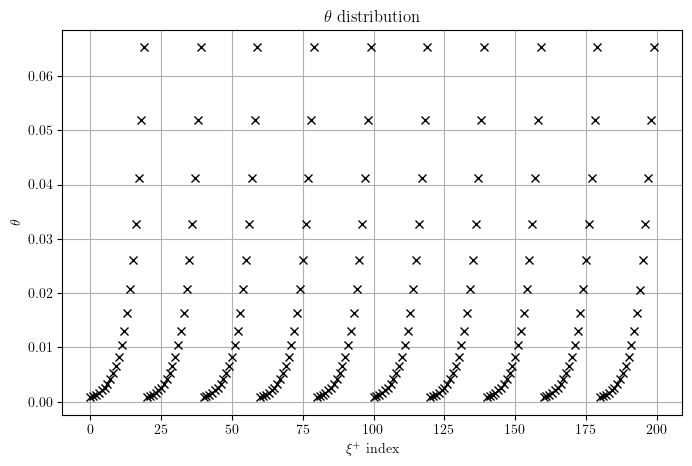

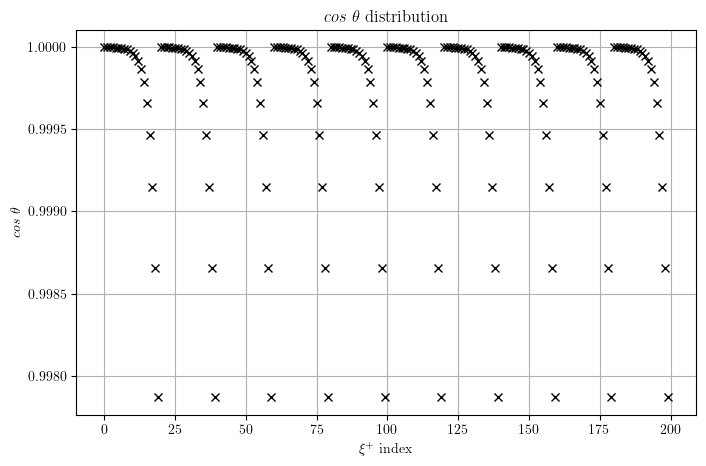

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation

file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    # hdul.info()
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

covmat_desy3 = covmat[:400, :400]
covmat_kids = covmat[400:, 400:]

des_xip_fulldata = [xip_data['VALUE'], # xip
                    xip_data['ANG'], # theta
                    xip_data['BIN1'], # i
                    xip_data['BIN2'], # j
                    ]

des_xim_fulldata = [xim_data['VALUE'], # xim
                    xim_data['ANG'], # theta
                    xim_data['BIN1'], # i
                    xim_data['BIN2'], # j
                    ]
n1 = nz_data_des['BIN1'].astype(np.float64)
n2 = nz_data_des['BIN2'].astype(np.float64)
n3 = nz_data_des['BIN3'].astype(np.float64)
n4 = nz_data_des['BIN4'].astype(np.float64)
z_s = nz_data_des['Z_MID'].astype(np.float64)

dz = np.diff(z_s)
dz = np.append(dz, dz[-1])
n1 /= np.sum(n1 * dz)
n2 /= np.sum(n1 * dz)
n3 /= np.sum(n1 * dz)
n4 /= np.sum(n1 * dz)

des_fulldata = [des_xip_fulldata,
                des_xim_fulldata,
                np.column_stack((n1,  # n_i(z) for i = 1
                                n2,   # ...
                                n3,   # ...
                                n4)).astype(np.float64), # n_i(z) for i = 4
                z_s,                  # z in n_i(z)
                covmat_desy3,
                ]

nb_l = 100
xi_range = np.arange(200)

### Theta distribution

thetas = xip_data['ANG'] * np.pi /(60 * 180)
cos_thetas = np.cos(thetas)
aL_pols = utils.polynoms.AssociatedLegendrePolynomsCalculator(nb_l).polynoms

plt.figure(figsize=(8,5))
plt.plot(xi_range, thetas, 'x', color='black')
plt.xlabel(r'$\xi^+$ index')
plt.ylabel(r'$\theta$')
plt.title(r'$\theta$ distribution')
plt.grid(True, which='both')

plt.figure(figsize=(8,5))
plt.plot(xi_range, cos_thetas, 'x', color='black')
plt.xlabel(r'$\xi^+$ index')
plt.ylabel(r'$cos\ \theta$')
plt.title(r'$cos\ \theta$ distribution')
plt.grid(True, which='both')

In [5]:
n1 = nz_data_des['BIN1'].astype(np.float64)
n2 = nz_data_des['BIN2'].astype(np.float64)
n3 = nz_data_des['BIN3'].astype(np.float64)
n4 = nz_data_des['BIN4'].astype(np.float64)

# n = nz_data_des['BIN1'].astype(np.float64)
# print(f'n(bin={1}, i_z={2}) = {n[2]}')
# print(f'{des_fulldata[2][2,0]}')

sum_n1 = np.sum(n1)
sum_n2 = np.sum(n2)
sum_n3 = np.sum(n3)
sum_n4 = np.sum(n4)

print(sum_n1)
print(sum_n2)
print(sum_n3)
print(sum_n4)
z_s = nz_data_des['Z_MID'].astype(np.float64)
# print(np.sum(n1 * z_s))
# l = n1 / sum_n1
dz = np.diff(z_s)
dz = np.append(dz, dz[-1])
n1 /= np.sum(n1 * dz)
n2 /= np.sum(n1 * dz)
n3 /= np.sum(n1 * dz)
n4 /= np.sum(n1 * dz)

print(np.where(n1< 5e-5))

0.9937285860782274
0.9801553977560606
0.9758783919848851
0.963081013805586
(array([ 86,  87,  88,  89,  90,  91, 101, 102, 103, 104, 105, 106]),)


In [19]:
import math
import numpy as np
from scipy.special import comb


def d22l_rec_P(theta, lmax, eps=1e-12):
    theta = np.asarray(theta)
    x = np.cos(theta)
    ntheta = x.size

    d22 = np.zeros((ntheta, lmax+1), dtype=float)

    Pm2 = np.zeros((lmax+1, ntheta), dtype=float)
    Pm2[2, :] = 3 * (1 - x**2)

    if lmax >= 3:
        Pm2[3, :] = 15 * x * (1 - x**2)

    m = 2
    for l in range(4, lmax+1):
        Pm2[l, :] = ((2*l - 1) * x * Pm2[l-1, :] - (l + m - 1) * Pm2[l-2, :]) / (l - m)

    for l in range(2, lmax+1):
        norm = np.sqrt(1 / ((l+2) * (l+1) * l * (l-1)))
        d22[:, l] = norm * Pm2[l, :]

    return d22

def d22_rec(theta, lmax):
    theta = np.asarray(theta)
    x = np.cos(theta)
    ntheta = x.size
    
    d22 = np.zeros((ntheta, lmax+1), dtype=float)
    
    d22[:,2] = 0.25 * (1 + x)**2
    
    if lmax >= 3:
        d22[:,3] = np.sqrt(3/8) * np.sin(theta)**2 * (1 + x)
    
    for l in range(3, lmax):
        num1 = (2*l+1) * x * (l-1)*(l+2) * d22[:,l]
        num2 = (l+2)*(l-1) * d22[:,l-1]
        d22[:,l+1] = num1/(l*(l+1)) - num2/(l*(l+1))
    
    return d22

def d22l_sum(theta, l):
    cos_half_theta = math.cos(theta / 2)
    sin_half_theta = math.sin(theta / 2)

    result = 0
    for k in range(l - 1):
        factorial_term = (math.factorial(l + 2) * math.factorial(l - 2)) / (math.factorial(l + 2 - k) *
                                                                            math.factorial(l - 2 - k) *
                                                                            comb(k * 2, k) ** 2)
        
        trig_term = (cos_half_theta**(2 * l - 4 * k)) * (sin_half_theta**(4 * k))
        result += (-1)**k * factorial_term * trig_term

    return result


file_path = 'DES-Y3_xipm_and_KiDS-1000_COSEBIs_2.0_300.0.fits'

with fits.open(file_path) as hdul:
    xip_data = hdul['xip'].data
    xim_data = hdul['xim'].data
    covmat = hdul['COVMAT'].data
    nz_data_des = hdul['nz_source_des'].data
    nz_source_kids = hdul['nz_source_kids'].data

covmat_desy3 = covmat[:400, :400]
covmat_kids = covmat[400:, 400:]

des_xip_fulldata = [xip_data['VALUE'], # xip
                    xip_data['ANG'], # theta
                    xip_data['BIN1'], # i
                    xip_data['BIN2'], # j
                    ]
nb_l = 10000
l = 200
# i_theta = 0
# theta = des_xip_fulldata[1][i_theta]

Gp_vals, Gm_vals, P_l2 = Gp_Gm(xip_data['ANG'], l_max=nb_l)

for i_theta in range(1):
    for l in range(1,10000,500):
        theta = des_xip_fulldata[1][i_theta]
        # print(f"My d_22(l={l}, theta={theta}) = {0.5 * (Gp_vals[l, i_theta] + Gm_vals[l, i_theta])}")
        print(f"Recurrent with P: d_22(l={l}, theta={theta}) = {d22l_rec_P(des_xip_fulldata[1], nb_l)[i_theta, l]}")
        # print(f"Recurrent d_22(l={l}, theta={theta}) = {d22_rec(des_xip_fulldata[1], nb_l)[i_theta, l]}")
        # print(f"Theoretical d_22(l={l}, theta={theta}) = {d22l_sum(theta, l)}\n")

d_22(l=1, theta=2.8290362127037185) = 0.0
d_22(l=501, theta=2.8290362127037185) = 0.02877823896418458
d_22(l=1001, theta=2.8290362127037185) = -0.015282728806693945
d_22(l=1501, theta=2.8290362127037185) = -0.03383502573799806
d_22(l=2001, theta=2.8290362127037185) = -0.0298950458691462
d_22(l=2501, theta=2.8290362127037185) = -0.01096643930755473
d_22(l=3001, theta=2.8290362127037185) = 0.010486131925591634
d_22(l=3501, theta=2.8290362127037185) = 0.022771218536618017
d_22(l=4001, theta=2.8290362127037185) = 0.020548441469725117
d_22(l=4501, theta=2.8290362127037185) = 0.0068681273352475996
d_22(l=5001, theta=2.8290362127037185) = -0.009314722894296858
d_22(l=5501, theta=2.8290362127037185) = -0.018568265535170315
d_22(l=6001, theta=2.8290362127037185) = -0.016230119308454877
d_22(l=6501, theta=2.8290362127037185) = -0.004614223901061514
d_22(l=7001, theta=2.8290362127037185) = 0.008840078689456061
d_22(l=7501, theta=2.8290362127037185) = 0.016177835848064023
d_22(l=8001, theta=2.8290

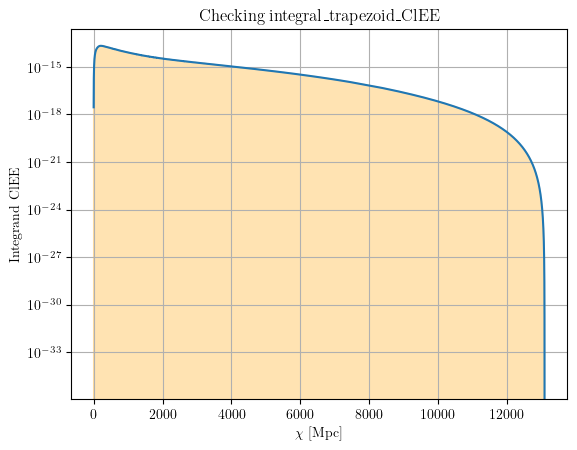

Integral value (np.trapz) = 2.4424128016976282e-11
Integral value (integral_trapezoid_ClEE) = 2.442377898890694e-11


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

chi_vals_but_not_chi_vals = np.linspace(1, chi_H, 100000)
vals = [integrand_ClEE(xx,
                       des_xip_fulldata[2][0], des_xip_fulldata[3][0], 2,
                       H0, Omega_m*h**2, Omega_m, Omega_b, Omega_gamma,
                       h, c, n_s, k_star, A_s, fact,
                       chi_H, chi_vals, des_fulldata[2], des_fulldata[3]) 
        for xx in chi_vals_but_not_chi_vals]

integrale = np.trapz(vals, chi_vals_but_not_chi_vals)

integrale_v2 = integral_trapezoid_ClEE(a=1e-6, b=chi_H, N=1000, i=des_xip_fulldata[2][0], j=des_xip_fulldata[3][0],
                                        l=2, H0=H0, omega_m=Omega_m*h**2, Omega_m=Omega_m, Omega_b=Omega_b,
                                        Omega_gamma=Omega_gamma, h=h, c=c, n_s=n_s, k_star=k_star, A_s=A_s,
                                        fact=fact, chi_H=chi_H, chi_vals=chi_vals, n_bins_list=des_fulldata[2],
                                        z_n_bins_list=des_fulldata[3])


plt.plot(chi_vals_but_not_chi_vals, vals)
plt.fill_between(chi_vals_but_not_chi_vals, vals, alpha=0.3, color="orange")

plt.xlabel(r"$\chi$ [Mpc]")
plt.ylabel("Integrand ClEE")
plt.yscale("log")
plt.grid(True)
plt.title('Checking integral_trapezoid_ClEE')
plt.show()

print("Integral value (np.trapz) =", integrale)
print("Integral value (integral_trapezoid_ClEE) =", integrale_v2)


## Comparison plots

-1.0039920763292391 -0.941865954665012 -0.9645675520018693
0.9729290154971255


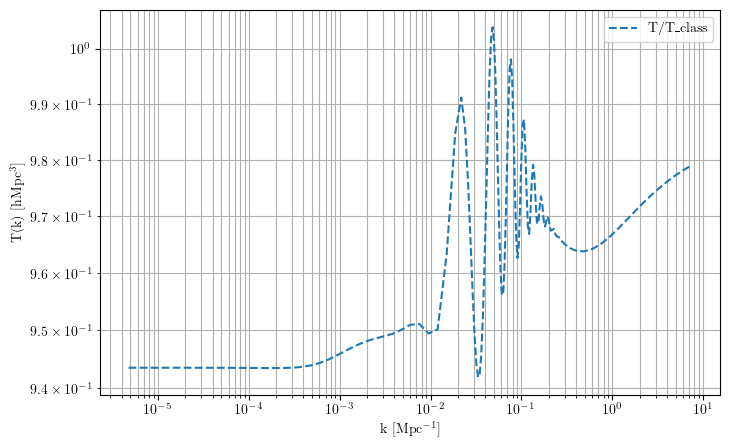

In [53]:
from classy import Class
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

### PARAMETERS

c = 299792.458
h = 0.674
Omega_m = 0.315
Omega_b = 0.049
Omega_gamma = 2.47e-5 / h**2
A_s = 2.1e-9
n_s = 0.965
k_pivot = 0.05   # 1/Mpc
z = 5 # entre 0 et 6 pour KiDS (0 et 3 pour DESy3)
N_eff = 3.046
R_nu = (0.2271 * N_eff) / (1 + 0.2271 * N_eff) # 0.2271 = 7/8*(4/11)**(4/3)
fact = 1 / (1 + (4/15) * R_nu)
fact *= 0.855 ## temporary to fit with CLASS

### CLASS
cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'dTk,mPk',
    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0
})
cosmo.compute()

transfer, k_grid, z_grid = cosmo.get_transfer_and_k_and_z()

compare = {
    'T-T_class': True,
    'P(T_class)-P_class': False,
    'P-P_class': False
}

iz = np.argmin(np.abs(z_grid - z))

if compare['P(T_class)-P_class']:
    plt.figure(figsize=(8,5))
    P_cal = utils.cosmo._P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=transfer['d_m'][:, iz])
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P(T_class)')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P(T_class)/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('P(k) [hMpc$^3$]')
    plt.legend();
if compare['T-T_class']:
    plt.figure(figsize=(8,5))
    T = utils.cosmo._T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    T_class = transfer['d_m'][:, iz]
    ratio = T / T_class
    print(ratio.min(), ratio.max(), ratio.mean())
    print(0.5*(np.abs(ratio).min()+np.abs(ratio).max()))
    # plt.loglog(h*k_grid, -T_class, label='T_class')
    # plt.loglog(h*k_grid, T, label='T')
    plt.loglog(h*k_grid, -T/T_class, '--', label='T/T_class')
    plt.grid(True, which='both')
    plt.xlabel('k [Mpc$^{-1}$]')
    plt.ylabel('T(k) [hMpc$^3$]')
    plt.legend();
if compare['P-P_class']:
    plt.figure(figsize=(8,5))
    # T = utils.T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    # P = utils.P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_cal = utils.cosmo.P(k_grid, z, Omega_m, Omega_b, Omega_gamma, h, c, n_s, k_pivot, A_s, fact)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P_cal / P_class
    print(ratio.min(), ratio.max(), ratio.mean())
    plt.loglog(h*k_grid, P_class, label='P_class')
    plt.loglog(h*k_grid, P_cal, label='P')
    plt.loglog(h*k_grid, P_cal/P_class, '--', label='P/P_class')
    plt.grid(True, which='both')
    plt.xlabel('k [hMpc$^{-1}$]')
    plt.ylabel('P(k) [Mpc$^3$]')
    plt.legend();

/tmp/ipykernel_20626/942024579.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("YlOrRd")


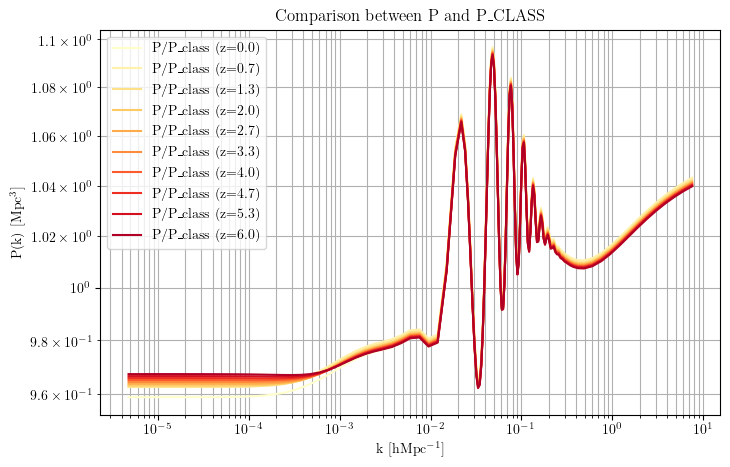

In [54]:
from matplotlib import cm  # colormaps
from matplotlib.colors import Normalize

cosmo = Class()
cosmo.set({
    'h': h,
    'omega_b': Omega_b * h**2,
    'omega_cdm': (Omega_m - Omega_b) * h**2,
    'A_s': A_s,
    'n_s': n_s,
    'output': 'mPk',

    'P_k_max_1/Mpc': 10.0,
    'z_max_pk': 5.0,
})
cosmo.compute()

k_vals = np.logspace(-3, 1, 124)

# Tracer
plt.figure(figsize=(8,5))
Nz = 10
z_array = np.linspace(0,6,Nz)

norm = Normalize(vmin=0, vmax=Nz)
cmap = cm.get_cmap("YlOrRd")
for i in range(len(z_array)):
    z = z_array[i]
    T = utils.cosmo._T_k_z(k=k_grid, z=z, Omega_m_0=Omega_m, Omega_b_0=Omega_b, Omega_gamma=Omega_gamma, h=h, c=c, fact=fact)
    P = utils.cosmo._P_k_z(k=k_grid, A_s=A_s, k_star=k_pivot, n_s=n_s, Tdm=T)
    P_class = np.array([cosmo.pk_lin(k, z) for k in k_grid])
    ratio = P / P_class
    plt.loglog(h*k_grid, P/P_class, color=cmap(norm(i)), label=f'P/P_class (z={z:.1f})')

plt.legend(); plt.xlabel('k [hMpc$^{-1}$]'); plt.ylabel('P(k) [Mpc$^3$]')
plt.title(f'Comparison between P and P_CLASS')
plt.grid(True, which='both')
plt.show()
